# Simulation And Analysis Of Stock Pricing Techniques
By: **Jai Garg (DTU/2K18/MC/044)** and **Jatin Papreja (DTU/2K18/MC/049)**. 

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import datetime as dt
from pandas import Series,DataFrame
import chart_studio.plotly as py
from plotly.tools import FigureFactory as FF
import matplotlib.ticker as mtick
import scipy.stats as ss

# Initializing Parameters For Generating Simulations

In [2]:
p = 500
S0 = 100
volatility = 0.8
T = 1/4
r = 0.8
roi = 0.03
start_date = dt.datetime(2021, 1, 1)
final_date = dt.datetime(2021, 4, 1)
freq = 'B'
color = ['#FF1A1A', '#17BC17', 'blue', 'magenta', '#652DC1', 'orange']
symbol = ['circle-open', 'diamond-open', 'triangle-up-open', 'square-open', 'diamond-open']
%matplotlib inline

# Creating Environment

In [3]:
class market_environment(object):

    def __init__(self, name, pricing_date):
        self.name = name
        self.pricing_date = pricing_date
        self.constants = {}
        self.lists = {}
        self.curves = {}
    
    def add_constant(self, key, constant):
        self.constants[key] = constant
    
    def get_constant(self, key):
        return self.constants[key]

    def add_list(self, key, list_object):
        self.lists[key] = list_object
    
    def get_list(self, key):
        return self.lists[key]

    def add_curve(self, key, curve):
        self.curves[key] = curve

    def get_curve(self, key):
        return self.curves[key]

    def add_environment(self, env):
        # overwrites existing values, if they exist
        for key in env.constants:
            self.constants[key] = env.constants[key]
        for key in env.lists:
            self.lists[key] = env.lists[key]
        for key in env.curves:
            self.curves[key] = env.curves[key]

# GBM Class

In [4]:
class geometric_brownian_motion(object):

    def __init__(self, name, mar_env):
        self.name = name
        self.pricing_date = mar_env.pricing_date
        self.initial_value = mar_env.get_constant('initial_value')
        self.volatility = mar_env.get_constant('volatility')
        self.final_date = mar_env.get_constant('final_date')
        self.currency = mar_env.get_constant('currency')
        self.frequency = mar_env.get_constant('frequency')
        self.paths = mar_env.get_constant('paths')
        self.short_rate = mar_env.get_constant('short_rate')

        try:
            # if time_grid in mar_env take this
            # (for portfolio valuation)
            self.time_grid = mar_env.get_list('time_grid')
        except:
            self.time_grid = None

    def update(self, initial_value=None, volatility=None, lamb=None, \
          mu=None, delta=None, final_date=None):
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if lamb is not None:
            self.lamb = lamb
        if mu is not None:
            self.mu = mu
        if delta is not None:
            self.delt = delta
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None
        
    def generate_time_grid(self):
        start = self.pricing_date 
        end = self.final_date
        # pandas date_range fundtion
        # freq = e.g. 'B' for Business Day,'W' for Weekly, 'M' for Monthly
        time_grid = pd.date_range(start=start, end=end, \
                                  freq=self.frequency).to_pydatetime()
        time_grid = list(time_grid)
        # enhane time_grid by start, end, and special_dates
        if start not in time_grid:
            time_grid.insert(0, start)
            # insert start date if not in list
        if end not in time_grid:
            time_grid.append(end)
            # insert end date if not in list

        self.time_grid = np.array(time_grid)

        
    def generate_paths(self, fixed_seed=False, day_count=365.):
        if self.time_grid is None:
            self.generate_time_grid()
            # method from generic simulation class
            # number of dates for time grid
        M = len(self.time_grid)
        # number of paths
        I = self.paths
        # array initialization for path simulation
        paths = np.zeros((M, I))
        # initialize first date with initial_value
        paths[0] = self.initial_value
        short_rate = self.short_rate
        
        # get short rate for drift of process
        for t in range(1, len(self.time_grid)):
            # select the right time slice from the relevant
            # random number set
            dt = (self.time_grid[t] - self.time_grid[t-1]).days / day_count
            rand = np.random.normal(loc = 0.0, scale = np.sqrt(dt), size = (1, I))
            ran = rand
            # difference between two dates as year fraction
            paths[t] = paths[t - 1] * np.exp((short_rate - (0.5 * (self.volatility**2)))*dt + (self.volatility*ran))
            # generate simulated values for the respective date
        self.instrument_values = paths

In [5]:
me_gbm1 = market_environment('me_gbm', start_date)
me_gbm1.add_constant('initial_value', S0)
me_gbm1.add_constant('volatility', volatility)
me_gbm1.add_constant('final_date', final_date)
me_gbm1.add_constant('currency', 'US')
me_gbm1.add_constant('frequency', freq)
me_gbm1.add_constant('paths', p)
me_gbm1.add_constant('short_rate', r)

gbm1 = geometric_brownian_motion('gbm', me_gbm1)
gbm1.generate_time_grid()
gbm1.generate_paths()
path_gbm1 = gbm1.instrument_values

## Monte-Carlo Simulation of Stock Prices under GBM

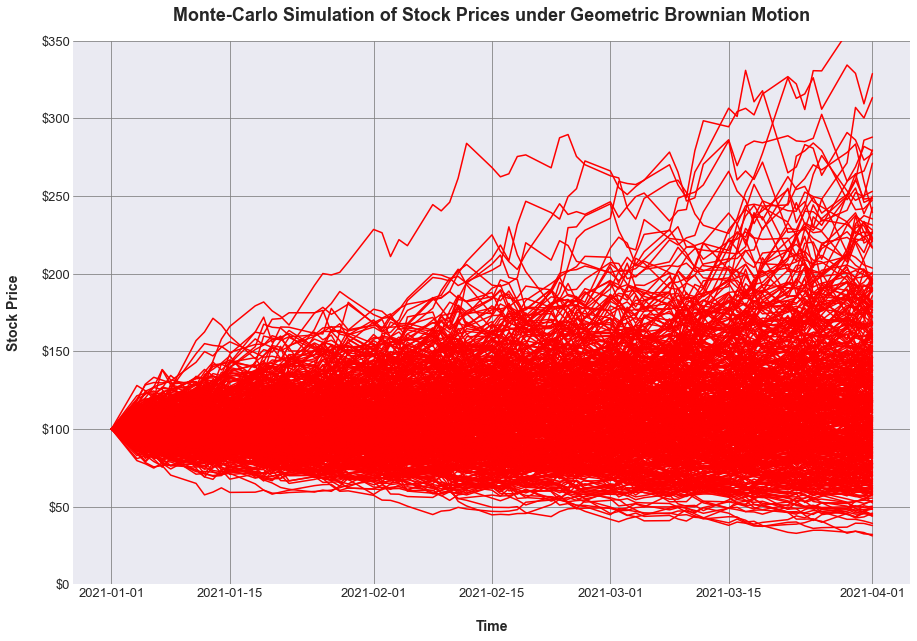

In [6]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1, 1,  figsize = (15, 10))
    plt.plot(gbm1.time_grid, path_gbm1, color = 'red', label = '<b>Geometric Brownian Motion</b>')
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    plt.grid(True, color = 'grey')
    plt.title('Monte-Carlo Simulation of Stock Prices under Geometric Brownian Motion', fontweight = 'bold', fontsize = 18, pad = 20)
    plt.ylabel('Stock Price', fontweight = 'bold', fontsize = 14, labelpad = 20)
    plt.xlabel('Time', fontweight = 'bold', fontsize = 14, labelpad = 20)
    plt.ylim(0, 350)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.show()

## Parameter Analysis

### For Drift

In [7]:
r = [0.4, 0.8, 2]

In [8]:
Stock_Prices = []
for r_i in r:
    me_gbm4 = market_environment('me_gbm', start_date)

    me_gbm4.add_constant('initial_value', S0)
    me_gbm4.add_constant('volatility', volatility)
    me_gbm4.add_constant('final_date', final_date)
    me_gbm4.add_constant('currency', 'US')
    me_gbm4.add_constant('frequency', '48H')
    me_gbm4.add_constant('paths', p)
    me_gbm4.add_constant('short_rate', r_i)
    # add jump diffusion specific parameters
    
    gbm4 = geometric_brownian_motion('gbm', me_gbm4)
    gbm4.generate_time_grid()
    gbm4.generate_paths()
    path_gbm4 = gbm4.instrument_values
    
    
    mean_path_gbm4 = np.zeros(len(path_gbm4))
    for i in range(len(path_gbm4)):
        mean_path_gbm4[i] = np.mean(path_gbm4[i])
        
    Stock_Prices.append(mean_path_gbm4)

In [9]:
import plotly.graph_objects as go
x =  gbm4.time_grid
fig = go.Figure()

# Add traces
for i in range(len(r)):
    fig.add_trace(go.Scatter(x = x, y = Stock_Prices[i],
                        mode='lines+markers',
                        name='Drift: ' + str(r[i]),
                        marker = {'symbol' : symbol[i], 'size' : 10, 'opacity' : 1},
                        line = {'dash' : 'solid', 'width' : 2.5, 'color' : color[i]}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 8))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b> Simulation of Geometric Brownian Motion for Different Values of Drift(µ) </b>", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

### For Volatility 

In [10]:
r = 0.8
volatility = [0.01, 0.8, 1.5]

In [11]:
Stock_Prices = []
for v_i in volatility:
    me_gbm5 = market_environment('me_gbm', start_date)

    me_gbm5.add_constant('initial_value', S0)
    me_gbm5.add_constant('volatility', v_i)
    me_gbm5.add_constant('final_date', final_date)
    me_gbm5.add_constant('currency', 'US')
    me_gbm5.add_constant('frequency', '48H')
    me_gbm5.add_constant('paths', p)
    me_gbm5.add_constant('short_rate', r)
    # add jump diffusion specific parameters
    
    gbm5 = geometric_brownian_motion('gbm', me_gbm5)
    gbm5.generate_time_grid()
    gbm5.generate_paths()
    path_gbm5 = gbm5.instrument_values
    
    
    mean_path_gbm5 = np.zeros(len(path_gbm5))
    for i in range(len(path_gbm5)):
        mean_path_gbm5[i] = np.mean(path_gbm5[i])
        
    Stock_Prices.append(mean_path_gbm5)

In [12]:
import plotly.graph_objects as go
x =  gbm5.time_grid
fig = go.Figure()

# Add traces
for i in range(len(volatility)):
    fig.add_trace(go.Scatter(x = x, y = Stock_Prices[i],
                        mode='lines+markers',
                        name='Volatility: ' + str(volatility[i]),
                        marker = {'symbol' : symbol[i], 'size' : 10, 'opacity' : 1},
                        line = {'dash' : 'solid', 'width' : 2.5, 'color' : color[i]}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 4))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b> Simulation of Geometric Brownian Motion for Different Values of Volatility(σ) </b>", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

In [13]:
p = 500
S0 = 100
volatility = 0.8
T = 1/4
r = 0.8
roi = 0.03
start_date = dt.datetime(2021, 1, 1)
final_date = dt.datetime(2021, 4, 1)

# Merton-Jump Diffusion Class

In [14]:
class jump_diffusion(object):
    
    def __init__(self, name, mar_env):
        self.name = name
        self.pricing_date = mar_env.pricing_date
        self.initial_value = mar_env.get_constant('initial_value')
        self.volatility = mar_env.get_constant('volatility')
        self.final_date = mar_env.get_constant('final_date')
        self.currency = mar_env.get_constant('currency')
        self.frequency = mar_env.get_constant('frequency')
        self.paths = mar_env.get_constant('paths')
        self.short_rate = mar_env.get_constant('short_rate')
        self.index = np.zeros(self.paths)
        
        # additional parameters needed
        self.lamb = mar_env.get_constant('lambda')
        self.mu = mar_env.get_constant('mu')
        self.delt = mar_env.get_constant('delta')
        self.instrument_values = None
        try:
            # if time_grid in mar_env take this
            # (for portfolio valuation)
            self.time_grid = mar_env.get_list('time_grid')
        except:
            self.time_grid = None
    
    def update(self, initial_value=None, volatility=None, lamb=None, \
           mu=None, delta=None, final_date=None):
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if lamb is not None:
            self.lamb = lamb
        if mu is not None:
            self.mu = mu
        if delta is not None:
            self.delt = delta
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None
        
    def generate_time_grid(self):
        start = self.pricing_date 
        end = self.final_date
        # pandas date_range fundtion
        # freq = e.g. 'B' for Business Day,'W' for Weekly, 'M' for Monthly
        time_grid = pd.date_range(start=start, end=end, \
                                  freq=self.frequency).to_pydatetime()
        time_grid = list(time_grid)
        # enhane time_grid by start, end, and special_dates
        if start not in time_grid:
            time_grid.insert(0, start)
            # insert start date if not in list
        if end not in time_grid:
            time_grid.append(end)
            # insert end date if not in list

        self.time_grid = np.array(time_grid)
        
    def generate_paths(self, fixed_seed=True, day_count=365.):
        if self.time_grid is None:
            self.generate_time_grid()
            
        M = len(self.time_grid)
        I = self.paths
        paths = np.zeros((M, I))
        paths[0] = self.initial_value  
        rj = self.lamb * (np.exp(self.mu + 0.5 * self.delt**2) - 1)
        short_rate = self.short_rate   
        
        for t in range(1, len(self.time_grid)):
            dt = (self.time_grid[t] - self.time_grid[t-1]).days / day_count
            ran1 = np.random.standard_normal((1, I))
            ran2 = np.random.standard_normal((1, I))
            poi = np.random.poisson(self.lamb * dt, I)
            
            for i in range(self.paths):
                if poi[i] == 1:
                    self.index[i] = 1
                    
            paths[t] = paths[t-1] * (np.exp((short_rate - rj - (0.5 * (self.volatility ** 2)))*dt 
                                            + (self.volatility*np.sqrt(dt)*ran1)) 
                                     + ((np.exp(self.mu + self.delt * ran2) - 1) * poi))
            
        self.instrument_values = paths

In [15]:
lamda = 1      # lamda = 0.8 , lamda = 0.3
mu = 0.4       # mu = 0.4 , mu = -0.75
de = 0.05      # de = 0.05 , de = 0.1

In [16]:
me_jd1 = market_environment('me_jd', start_date)

me_jd1.add_constant('initial_value', S0)
me_jd1.add_constant('volatility', volatility)
me_jd1.add_constant('final_date', final_date)
me_jd1.add_constant('currency', 'US')
me_jd1.add_constant('frequency', freq)
me_jd1.add_constant('paths', p)
me_jd1.add_constant('short_rate', r)
# add jump diffusion specific parameters
me_jd1.add_constant('lambda', lamda)
me_jd1.add_constant('mu', mu)
me_jd1.add_constant('delta', de)
jd1 = jump_diffusion('jd', me_jd1)
jd1.generate_time_grid()
jd1.generate_paths()
path_jd1 = jd1.instrument_values
index_jd1 = jd1.index

## Monte-Carlo Simulation of Stock Prices under MJD

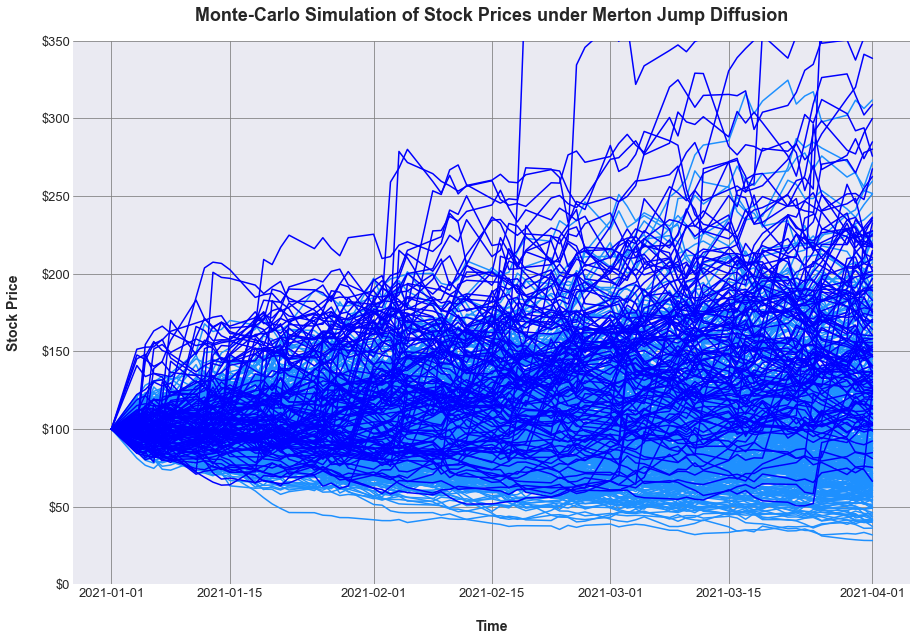

In [17]:
path1_1_jd1 = [i for i in range(p) if index_jd1[i] == 0]
path1_2_jd1 = [i for i in range(p) if index_jd1[i] == 1]

with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1, 1,  figsize = (15, 10))
    plt.plot(jd1.time_grid, path_jd1[:, path1_1_jd1], color = 'dodgerblue', label = '<b>Jump Diffusion</b>')
    plt.plot(jd1.time_grid, path_jd1[:, path1_2_jd1], color = 'blue', label = 'Jump Diffusion')
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    plt.grid(True, color = 'grey')
    plt.title('Monte-Carlo Simulation of Stock Prices under Merton Jump Diffusion', fontweight = 'bold', fontsize = 18, pad = 20)
    plt.ylabel('Stock Price', fontweight = 'bold', fontsize = 14, labelpad = 20)
    plt.xlabel('Time', fontweight = 'bold', fontsize = 14, labelpad = 20)
    plt.ylim(0, 350)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.show()

## Parameter Analysis

### For Lambda

In [18]:
mu = 0.5
de = 0.5
lamda = [0, 2.5, 5]

In [19]:
Stock_Prices = []
for lam in lamda:
    me_jd2 = market_environment('me_jd', start_date)

    me_jd2.add_constant('initial_value', S0)
    me_jd2.add_constant('volatility', volatility)
    me_jd2.add_constant('final_date', final_date)
    me_jd2.add_constant('currency', 'US')
    me_jd2.add_constant('frequency', '48H')
    me_jd2.add_constant('paths', p)
    me_jd2.add_constant('short_rate', r)
    # add jump diffusion specific parameters
    me_jd2.add_constant('lambda', lam)
    me_jd2.add_constant('mu', mu)
    me_jd2.add_constant('delta', de)
    jd2 = jump_diffusion('jd', me_jd2)
    jd2.generate_time_grid()
    jd2.generate_paths()
    path_jd2 = jd2.instrument_values
    index_jd2 = jd2.index
    
    mean_path_jd2 = np.zeros(len(path_jd2))
    for i in range(len(path_jd2)):
        mean_path_jd2[i] = np.mean(path_jd2[i])
        
    Stock_Prices.append(mean_path_jd2)

In [20]:
import plotly.graph_objects as go
x =  jd2.time_grid
fig = go.Figure()

# Add traces
for i in range(len(lamda)):
    fig.add_trace(go.Scatter(x = x, y = Stock_Prices[i],
                        mode='lines+markers',
                        name='Lambda: ' + str(lamda[i]),
                        marker = {'symbol' : symbol[i], 'size' : 10, 'opacity' : 1},
                        line = {'dash' : 'solid', 'width' : 2.5, 'color' : color[i]}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 4))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b> Simulation of Merton-Jump Diffusion Process for Different Values of Lambda(λ) </b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

### For Gamma

In [21]:
de = 0.05
lamda = 1
mu = [0, 0.3, 1]

In [22]:
Stock_Prices = []
for mu_i in mu:
    me_jd3 = market_environment('me_jd', start_date)

    me_jd3.add_constant('initial_value', S0)
    me_jd3.add_constant('volatility', volatility)
    me_jd3.add_constant('final_date', final_date)
    me_jd3.add_constant('currency', 'US')
    me_jd3.add_constant('frequency', '48H')
    me_jd3.add_constant('paths', p)
    me_jd3.add_constant('short_rate', r)
    # add jump diffusion specific parameters
    me_jd3.add_constant('lambda', lam)
    me_jd3.add_constant('mu', mu_i)
    me_jd3.add_constant('delta', de)
    jd3 = jump_diffusion('jd', me_jd3)
    jd3.generate_time_grid()
    jd3.generate_paths()
    path_jd3 = jd3.instrument_values
    index_jd3 = jd3.index
    
    mean_path_jd3 = np.zeros(len(path_jd3))
    for i in range(len(path_jd3)):
        mean_path_jd3[i] = np.mean(path_jd3[i])
        
    Stock_Prices.append(mean_path_jd3)

In [23]:
import plotly.graph_objects as go
x =  jd3.time_grid
fig = go.Figure()

# Add traces
for i in range(len(mu)):
    fig.add_trace(go.Scatter(x = x, y = Stock_Prices[i],
                        mode='lines+markers',
                        name='Gamma: ' + str(mu[i]),
                        marker = {'symbol' : symbol[i], 'size' : 10, 'opacity' : 1},
                        line = {'dash' : 'solid', 'width' : 2.5, 'color' : color[i]}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 4))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b> Simulation of Merton-Jump Diffusion Process for Different Values of Gamma(γ) </b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

### For Delta

In [24]:
lamda = 1
mu = 0.5
de = [0, 0.3, 0.6]

In [25]:
Stock_Prices = []
for de_i in de:
    me_jd4 = market_environment('me_jd', start_date)

    me_jd4.add_constant('initial_value', S0)
    me_jd4.add_constant('volatility', volatility)
    me_jd4.add_constant('final_date', final_date)
    me_jd4.add_constant('currency', 'US')
    me_jd4.add_constant('frequency', '48H')
    me_jd4.add_constant('paths', p)
    me_jd4.add_constant('short_rate', r)
    # add jump diffusion specific parameters
    me_jd4.add_constant('lambda', lam)
    me_jd4.add_constant('mu', mu)
    me_jd4.add_constant('delta', de_i)
    jd4 = jump_diffusion('jd', me_jd4)
    jd4.generate_time_grid()
    jd4.generate_paths()
    path_jd4 = jd4.instrument_values
    index_jd4 = jd4.index
    
    mean_path_jd4 = np.zeros(len(path_jd4))
    for i in range(len(path_jd4)):
        mean_path_jd4[i] = np.mean(path_jd4[i])
        
    Stock_Prices.append(mean_path_jd4)

In [26]:
import plotly.graph_objects as go
x =  jd4.time_grid
fig = go.Figure()

# Add traces
for i in range(len(de)):
    fig.add_trace(go.Scatter(x = x, y = Stock_Prices[i],
                        mode='lines+markers',
                        name='Delta: ' + str(de[i]),
                        marker = {'symbol' : symbol[i], 'size' : 10, 'opacity' : 1},
                        line = {'dash' : 'solid', 'width' : 2.5, 'color' : color[i]}))


# fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b> Simulation of Merton-Jump Diffusion Process for Different Values of Delta(δ) </b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.show()

# Heston Process Class

In [27]:
class Heston(object):
    
    def __init__(self, name, mar_env):
        self.name = name
        self.pricing_date = mar_env.pricing_date
        self.initial_value = mar_env.get_constant('initial_value')
        self.volatility = mar_env.get_constant('volatility')
        self.final_date = mar_env.get_constant('final_date')
        self.currency = mar_env.get_constant('currency')
        self.frequency = mar_env.get_constant('frequency')
        self.paths = mar_env.get_constant('paths')
        self.short_rate = mar_env.get_constant('short_rate')
        self.index = np.zeros(self.paths)
        
        
        # additional parameters needed
        self.mu = mar_env.get_constant('mu')
        self.kappa = mar_env.get_constant('kappa')
        self.theta = mar_env.get_constant('theta')
        self.rho = mar_env.get_constant('rho')
        self.instrument_values = None
        try:
            # if time_grid in mar_env take this
            # (for portfolio valuation)
            self.time_grid = mar_env.get_list('time_grid')
        except:
            self.time_grid = None
    
    def update(self, initial_value=None, volatility=None, lamb=None, \
           mu=None, delta=None, final_date=None):
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if lamb is not None:
            self.lamb = lamb
        if mu is not None:
            self.mu = mu
        if delta is not None:
            self.delt = delta
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None
        
    def generate_time_grid(self):
        start = self.pricing_date 
        end = self.final_date
        # pandas date_range fundtion
        # freq = e.g. 'B' for Business Day,'W' for Weekly, 'M' for Monthly
        time_grid = pd.date_range(start=start, end=end, \
                                  freq=self.frequency).to_pydatetime()
        time_grid = list(time_grid)
        # enhane time_grid by start, end, and special_dates
        if start not in time_grid:
            time_grid.insert(0, start)
            # insert start date if not in list
        if end not in time_grid:
            time_grid.append(end)
            # insert end date if not in list

        self.time_grid = np.array(time_grid)
        
    def generate_paths(self, fixed_seed=True, day_count=365.):
        if self.time_grid is None:
            self.generate_time_grid()
        M = len(self.time_grid)
        I = self.paths
        paths = np.zeros((M, I))
        paths[0] = self.initial_value     
        short_rate = self.short_rate 
        X0 = np.log(self.initial_value)
        v0 = 0.04
        Y0 = np.log(v0)
        MU = np.array([0, 0])
        COV = np.matrix([[1, self.rho], [self.rho, 1]])
        W = ss.multivariate_normal.rvs( mean=MU, cov=COV, size=(I, M), random_state = 0)
        W_S = W[:,:,0]
        W_v = W[:,:,1]
        Y = np.zeros((I, M))
        Y[:,0] = Y0
        X = np.zeros((I,M))
        X[:,0] = X0
        v = np.zeros(M)
        
        for t in range(0, len(self.time_grid)-1):
            dt = (self.time_grid[t+1] - self.time_grid[t]).days / day_count
            v = np.exp(Y[:, t])
            v_sq = np.sqrt(v)
            Y[:,t+1] = Y[:,t] + (1/v)*(self.kappa*(self.theta - v) - 0.5*self.volatility**2 )*dt + self.volatility * (1/v_sq) * np.sqrt(dt) * W_v[:,t]   
            X[:,t+1] = X[:,t] + (self.mu - 0.5*v)*dt + v_sq * np.sqrt(dt) * W_S[:,t]

        paths = np.exp(X.T)
        self.instrument_values = paths

In [28]:
kappa = 4      # kappa = 2
theta = 1.5    # theta = 1
rho = 0.3      # rho = -0.2

In [29]:
me_hes1 = market_environment('me_hes', start_date)
me_hes1.add_constant('initial_value', S0)
me_hes1.add_constant('volatility', volatility)
me_hes1.add_constant('final_date', final_date)
me_hes1.add_constant('currency', 'US')
me_hes1.add_constant('frequency', freq)
me_hes1.add_constant('paths', p)
me_hes1.add_constant('short_rate', r)
me_hes1.add_constant('kappa', kappa)
me_hes1.add_constant('theta', theta)
me_hes1.add_constant('mu', r)
me_hes1.add_constant('rho', rho)

hes1 = Heston('hes', me_hes1)
hes1.generate_time_grid()
hes1.generate_paths()
path_hes1 = hes1.instrument_values

## Monte-Carlo Simulation of Stock Prices under HP

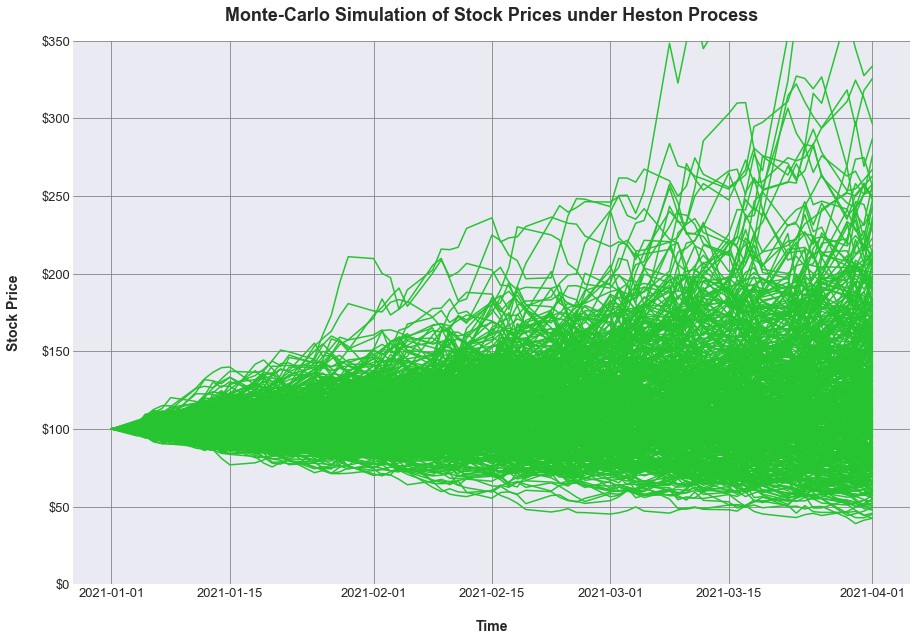

In [30]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1, 1,  figsize = (15, 10))
    plt.plot(hes1.time_grid, path_hes1, color = '#27C431', label = '<b>Geometric Brownian Motion</b>')
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    plt.grid(True, color = 'grey')
    plt.title('Monte-Carlo Simulation of Stock Prices under Heston Process', fontweight = 'bold', fontsize = 18, pad = 20)
    plt.ylabel('Stock Price', fontweight = 'bold', fontsize = 14, labelpad = 20)
    plt.xlabel('Time', fontweight = 'bold', fontsize = 14, labelpad = 20)
    plt.ylim(0, 350)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.show()

## Parameter Analysis

### For Rho

In [31]:
kappa = 4
theta = 1.5
rho = [0, 0.1, 1]

In [32]:
Stock_Prices = []
for rho_i in rho:
    me_hes2 = market_environment('me_hes', start_date)
    me_hes2.add_constant('initial_value', S0)
    me_hes2.add_constant('volatility', volatility)
    me_hes2.add_constant('final_date', final_date)
    me_hes2.add_constant('currency', 'US')
    me_hes2.add_constant('frequency', '48H')
    me_hes2.add_constant('paths', p)
    me_hes2.add_constant('short_rate', r)
    me_hes2.add_constant('kappa', kappa)
    me_hes2.add_constant('theta', theta)
    me_hes2.add_constant('mu', r)
    me_hes2.add_constant('rho', rho_i)
    
    hes2 = Heston('hes', me_hes2)
    hes2.generate_time_grid()
    hes2.generate_paths()
    path_hes2 = hes2.instrument_values
    mean_path_hes2 = np.zeros(len(path_hes2))
    for i in range(len(path_hes2)):
        mean_path_hes2[i] = np.mean(path_hes2[i])
        
    Stock_Prices.append(mean_path_hes2)

In [33]:
import plotly.graph_objects as go
x =  hes2.time_grid
fig = go.Figure()

# Add traces
for i in range(len(rho)):
    fig.add_trace(go.Scatter(x = x, y = Stock_Prices[i],
                        mode='lines+markers',
                        name='Rho: ' + str(rho[i]),
                        marker = {'symbol' : symbol[i], 'size' : 10, 'opacity' : 1},
                        line = {'dash' : 'solid', 'width' : 2.5, 'color': color[i]}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 4))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b> Simulation of Heston Process for Different Values of Rho(ρ) </b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

### For Kappa

In [34]:
theta = 1.5
rho = 0.3
kappa = [1, 10, 20]

In [35]:
Stock_Prices = []
for kappa_i in kappa:
    me_hes3 = market_environment('me_hes', start_date)
    me_hes3.add_constant('initial_value', S0)
    me_hes3.add_constant('volatility', volatility)
    me_hes3.add_constant('final_date', final_date)
    me_hes3.add_constant('currency', 'US')
    me_hes3.add_constant('frequency', '48H')
    me_hes3.add_constant('paths', p)
    me_hes3.add_constant('short_rate', r)
    me_hes3.add_constant('kappa', kappa_i)
    me_hes3.add_constant('theta', theta)
    me_hes3.add_constant('mu', r)
    me_hes3.add_constant('rho', rho)
    
    hes3 = Heston('hes', me_hes3)
    hes3.generate_time_grid()
    hes3.generate_paths()
    path_hes3 = hes3.instrument_values
    mean_path_hes3 = np.zeros(len(path_hes3))
    for i in range(len(path_hes3)):
        mean_path_hes3[i] = np.mean(path_hes3[i])
        
    Stock_Prices.append(mean_path_hes3)

In [36]:
import plotly.graph_objects as go
x =  hes3.time_grid
fig = go.Figure()

# Add traces
for i in range(len(kappa)):
    fig.add_trace(go.Scatter(x = x, y = Stock_Prices[i],
                        mode='lines+markers',
                        name='Kappa: ' + str(kappa[i]),
                        marker = {'symbol' : symbol[i], 'size' : 10, 'opacity' : 1},
                        line = {'dash' : 'solid', 'width' : 2.5, 'color': color[i]}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 4))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b> Simulation of Heston Process for Different Values of Kappa(k) </b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

### For Theta

In [37]:
kappa = 4
rho = 0.3
theta = [1, 5, 8]

In [38]:
Stock_Prices = []
for theta_i in theta:
    me_hes3 = market_environment('me_hes', start_date)
    me_hes3.add_constant('initial_value', S0)
    me_hes3.add_constant('volatility', volatility)
    me_hes3.add_constant('final_date', final_date)
    me_hes3.add_constant('currency', 'US')
    me_hes3.add_constant('frequency', '48H')
    me_hes3.add_constant('paths', p)
    me_hes3.add_constant('short_rate', r)
    me_hes3.add_constant('kappa', kappa)
    me_hes3.add_constant('theta', theta_i)
    me_hes3.add_constant('mu', r)
    me_hes3.add_constant('rho', rho)
    
    hes3 = Heston('hes', me_hes3)
    hes3.generate_time_grid()
    hes3.generate_paths()
    path_hes3 = hes3.instrument_values
    mean_path_hes3 = np.zeros(len(path_hes3))
    for i in range(len(path_hes3)):
        mean_path_hes3[i] = np.mean(path_hes3[i])
        
    Stock_Prices.append(mean_path_hes3)

In [39]:
import plotly.graph_objects as go
x =  hes3.time_grid
fig = go.Figure()

# Add traces
for i in range(len(theta)):
    fig.add_trace(go.Scatter(x = x, y = Stock_Prices[i],
                        mode='lines+markers',
                        name='Theta: ' + str(theta[i]),
                        marker = {'symbol' : symbol[i], 'size' : 10, 'opacity' : 1},
                        line = {'dash' : 'solid', 'width' : 2.5, 'color': color[i]}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 4))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b> Simulation of Heston Process for Different Values of Theta(Θ) </b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

# Function for Getting Stock Price Values from Dataset

In [40]:
import pandas as pd
from datetime import datetime
from dateutil import parser
def get_market_price(dataset, start_date, end_date):
    df = pd.read_csv(dataset)
    for i, val in enumerate(df["Date"]):
        df["Date"][i] = parser.parse(val)
        
    start_date =  start_date + ' 00:00:00'
    end_date = end_date + ' 00:00:00'
    df1 = df[df["Date"] >= parser.parse(start_date)]
    df1 = df1[df1["Date"] <= parser.parse(end_date)]
    delta = parser.parse(start_date) - parser.parse(end_date)
    list_index = []
    df1.reset_index(drop=True, inplace=True)
    for i, val in enumerate(df1["Date"]):
        if i >= 1:
            delta = df1["Date"][i] - df1["Date"][i-1]
            if delta.days == 2:
                list_index.append(i-1)
            elif delta.days == 4:
                list_index.append(i-1)
    df2 = df1['Adj Close'] 
    market_dash = list(df2)
    len(market_dash)
    market_dash1 = []
    for j in range(len(market_dash)):
        if j in list_index:
            market_dash1.append(market_dash[j])
        market_dash1.append(market_dash[j])
    market_dash1 = list(np.round(np.array(market_dash1), 2))
    return market_dash1

# Apple Stock Price Predictions

## Getting Stock Price Values

In [41]:
Dataset = 'AAPL.csv'
start_date = '2019-11-26'
end_date = '2020-02-04'
market1 = get_market_price(Dataset, start_date, end_date)
len(market1)
print(market1)

[65.41, 66.29, 66.29, 66.14, 65.38, 64.21, 64.78, 65.73, 67.0, 66.06, 66.45, 67.01, 67.18, 68.1, 69.26, 69.4, 69.23, 69.3, 69.16, 70.29, 70.35, 70.35, 71.75, 71.72, 72.15, 72.68, 72.68, 74.33, 73.61, 74.2, 73.85, 75.04, 76.63, 76.8, 78.44, 77.39, 77.05, 78.02, 78.88, 78.88, 78.35, 78.63, 79.01, 78.78, 76.46, 78.62, 80.27, 80.15, 76.6, 76.39, 78.91]


C:\Users\52jai\Envs\project_ml\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Initializing Parameters for Apple Stock Price Predictions

In [42]:
p = 500
S0 = 65.40
volatility = 0.8
T = 1/4
r = 0.8
start_date = dt.datetime(2019, 11, 26)
final_date = dt.datetime(2020, 2, 4)
freq = 'B'

## Creating GBM Model

In [43]:
me_gbm2 = market_environment('me_gbm', start_date)
me_gbm2.add_constant('initial_value', S0)
me_gbm2.add_constant('volatility', volatility)
me_gbm2.add_constant('final_date', final_date)
me_gbm2.add_constant('currency', 'US')
me_gbm2.add_constant('frequency', freq)
me_gbm2.add_constant('paths', p)
me_gbm2.add_constant('short_rate', r)

gbm2 = geometric_brownian_motion('gbm', me_gbm2)
gbm2.generate_time_grid()
gbm2.generate_paths()
path_gbm2 = gbm2.instrument_values

## Creating Merton-Jump Diffusion Model

In [44]:
lamda = 1
mu = 0.6
de = 0.6

me_jd5 = market_environment('me_jd', start_date)
me_jd5.add_constant('initial_value', S0)
me_jd5.add_constant('volatility', volatility)
me_jd5.add_constant('final_date', final_date)
me_jd5.add_constant('currency', 'US')
me_jd5.add_constant('frequency', freq)
me_jd5.add_constant('paths', p)
me_jd5.add_constant('short_rate', r)
me_jd5.add_constant('lambda', lamda)
me_jd5.add_constant('mu', mu)
me_jd5.add_constant('delta', de)
jd5 = jump_diffusion('jd', me_jd5)
jd5.generate_time_grid()
jd5.generate_paths()
path_jd5 = jd5.instrument_values
index_jd5 = jd5.index

## Creating Heston Process Model

In [45]:
kappa = 4
theta = 1.5
rho = 0.3

me_hes4 = market_environment('me_hes', start_date)
me_hes4.add_constant('initial_value', S0)
me_hes4.add_constant('volatility', volatility)
me_hes4.add_constant('final_date', final_date)
me_hes4.add_constant('currency', 'US')
me_hes4.add_constant('frequency', freq)
me_hes4.add_constant('paths', p)
me_hes4.add_constant('short_rate', r)
me_hes4.add_constant('kappa', kappa)
me_hes4.add_constant('theta', theta)
me_hes4.add_constant('mu', r)
me_hes4.add_constant('rho', rho)
hes4 = Heston('hes', me_hes4)
hes4.generate_time_grid()
hes4.generate_paths()
path_hes4 = hes4.instrument_values

In [46]:
mean_gbm2 = np.zeros(len(path_gbm2))
mean_jd5 = np.zeros(len(path_jd5))
mean_hes4 = np.zeros(len(path_hes4))

for i in range(len(path_gbm2)):
    mean_gbm2[i] = np.mean(path_gbm2[i])
    mean_jd5[i] = np.mean(path_jd5[i])
    mean_hes4[i] = np.mean(path_hes4[i])

In [47]:
import plotly.graph_objects as go
x =  hes4.time_grid
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x = x, y = mean_hes4,
                    mode='lines+markers',
                    name='Heston Process',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'magenta'}))
fig.add_trace(go.Scatter(x = x, y = mean_gbm2,
                    mode='lines+markers',
                    name='Geometric Brownian Motion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#FF1A1A'}))
fig.add_trace(go.Scatter(x = x, y = mean_jd5,
                    mode='lines+markers',
                    name='Jump Diffusion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#17BC17'}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))
fig.update_layout(autosize = False, height = 700, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 16}),
                  title={'text': "<b>Comparison of Apple Stock Price Predictions</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.show()

In [48]:
import plotly.graph_objects as go
x =  hes4.time_grid
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x = x, y = mean_hes4,
                    mode='lines+markers',
                    name='Heston Process',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'magenta'}))
fig.add_trace(go.Scatter(x = x, y = mean_gbm2,
                    mode='lines+markers',
                    name='Geometric Brownian Motion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#FF1A1A'}))
fig.add_trace(go.Scatter(x = x, y = mean_jd5,
                    mode='lines+markers',
                    name='Merton-Jump Diffusion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#17BC17'}))
fig.add_trace(go.Scatter(x = x, y = market1,
                    mode='lines+markers',
                    name='APPLE Stock Price',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'blue'}))

fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))
fig.update_layout(autosize = False, height = 700, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 16}),
                  title={'text': "<b>Comparison of Apple Stock Price Predictions with Actual Stock Price</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

## Individual Analysis

In [49]:
import plotly.graph_objects as go
x =  hes4.time_grid
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x = x, y = mean_gbm2,
                    mode='lines+markers',
                    name='Geometric Brownian Motion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#FF1A1A'}))

fig.add_trace(go.Scatter(x = x, y = market1,
                    mode='lines+markers',
                    name='APPLE Stock Price',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'blue'}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))
fig.update_layout(autosize = False, height = 700, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 16}),
                  title={'text': "<b>Apple Stock Price Predictions using GBM</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

In [50]:
import plotly.graph_objects as go
x =  hes4.time_grid
fig = go.Figure()

# Add traces


fig.add_trace(go.Scatter(x = x, y = mean_jd5,
                    mode='lines+markers',
                    name='Merton-Jump Diffusion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#17BC17'}))
fig.add_trace(go.Scatter(x = x, y = market1,
                    mode='lines+markers',
                    name='APPLE Stock Price',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'blue'}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))
fig.update_layout(autosize = False, height = 700, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 16}),
                  title={'text': "<b>Apple Stock Price Predictions using Merton-Jump Diffusion</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

In [51]:
import plotly.graph_objects as go
x =  hes4.time_grid
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x = x, y = mean_hes4,
                    mode='lines+markers',
                    name='Heston Process',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'magenta'}))
fig.add_trace(go.Scatter(x = x, y = market1,
                    mode='lines+markers',
                    name='APPLE Stock Price',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'blue'}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))
fig.update_layout(autosize = False, height = 700, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 16}),
                  title={'text': "<b>Apple Stock Price Predictions using Heston Process</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

## Monte Carlo Simulation Comparison

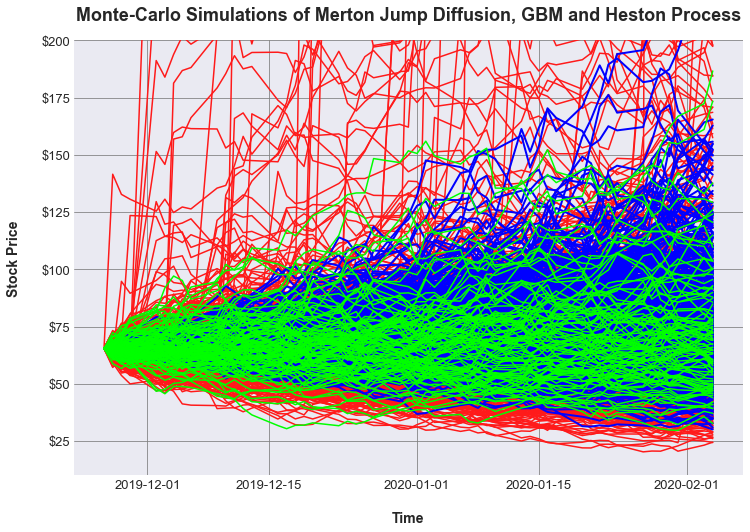

In [52]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1, 1,  figsize = (12, 8))
    plt.plot(jd5.time_grid, path_jd5[:, :p], '#FF1A1A', label = 'Jump Diffusion', linewidth = 1.5)
    plt.plot(hes4.time_grid, path_hes4[:, :p], 'blue', label = 'heston', linewidth = 2)
    plt.plot(gbm2.time_grid, path_gbm2[:, :100], 'lime', label = 'Geometric Brownian Motion', linewidth = 1.5)

    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    plt.grid(True, color = 'grey')
    plt.title('Monte-Carlo Simulations of Merton Jump Diffusion, GBM and Heston Process', fontweight = 'bold', fontsize = 18, pad = 20)
    plt.ylabel('Stock Price', fontweight = 'bold', fontsize = 14, labelpad = 20)
    plt.xlabel('Time', fontweight = 'bold', fontsize = 14, labelpad = 20)
    plt.ylim(10, 200)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.show()

## Error Analysis

In [53]:
error_jd5 = []
error_gbm2 = []
error_heston4 = []
er_jd5 = []
er_gbm2 = []
er_heston4 = []
for i in range(len(market1)):
    error_jd5.append(((mean_jd5[i] - market1[i])/market1[i])**2)
    error_gbm2.append(((mean_gbm2[i] - market1[i])/market1[i])**2)
    error_heston4.append(((mean_hes4[i] - market1[i])/market1[i])**2)
    er_jd5.append(abs((mean_jd5[i] - market1[i])/market1[i]))
    er_gbm2.append(abs((mean_gbm2[i] - market1[i])/market1[i]))
    er_heston4.append(abs((mean_hes4[i] - market1[i])/market1[i]))

mean_square_error_jd5 = sum(error_jd5)/len(error_jd5)
mean_square_error_gbm2 = sum(error_gbm2)/len(error_gbm2)
mean_square_error_heston4 = sum(error_heston4)/len(error_heston4)
print('\033[1m')
print("Root Mean Square Error:")

from termcolor import colored 
print(colored('Geometric Brownian Motion: {:.5f}', 'red', None, ['bold']).format(math.sqrt(mean_square_error_gbm2)))
print(colored('Merton Jump Diffusion: {:.5f}', 'green', None, ['bold']).format(math.sqrt(mean_square_error_jd5)))
print(colored('Heston Process:  {:.5f}', 'magenta', None, ['bold']).format(math.sqrt(mean_square_error_heston4)))


Root Mean Square Error:
Geometric Brownian Motion: 0.03846
Merton Jump Diffusion: 0.03994
Heston Process:  0.02522


In [54]:
er_heston4 = 100*np.array(er_heston4)
er_gbm2 = 100*np.array(er_gbm2)
er_jd5 = 100*np.array(er_jd5)

In [55]:
import plotly.graph_objects as go
x =  hes4.time_grid
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x = x, y = er_heston4,
                    mode='lines+markers',
                    name='Heston Process',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'magenta'}))
fig.add_trace(go.Scatter(x = x, y = er_gbm2,
                    mode='lines+markers',
                    name='Geometric Brownian Motion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#FF1A1A'}))
fig.add_trace(go.Scatter(x = x, y = er_jd5,
                    mode='lines+markers',
                    name='Jump Diffusion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#17BC17'}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 12}),
                  title={'text': "<b>Comparison of Percentage Error at each time step</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Percentage Error</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix=" ", ticksuffix = "%  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

## Call Option Pricing

### GBM

In [56]:
K = []
for i in range(66, 82, 3):
    K.append(i)
    
fig = go.Figure()
symbol = ['star-open', 'circle-open', 'triangle-up-open', 'square-open', 'diamond-open', 'hexagram-open']
j = 0
for k in K:
    C = []
    for i in range(len(market1)):
        c = (1/((1+roi)**((i*2)/365))*(max(mean_gbm2[i] - k, 0)))
        C.append(c)
    fig.add_trace(go.Scatter(x = gbm2.time_grid, y = C,
                    mode='lines+markers',
                    name='Strike Price: $' + str(k),
                    marker = {'symbol' : symbol[j], 'size' : 8, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color': color[j]}))
    j += 1

fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))#, range = (-1, 30)))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b>Call Option Pricing using GBM Process for various Strike Prices</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Call Option Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.show()

### Merton-Jump Diffusion

In [57]:
K = []
for i in range(66, 82, 3):
    K.append(i)
    
fig = go.Figure()
symbol = ['star-open', 'circle-open', 'triangle-up-open', 'square-open', 'diamond-open', 'hexagram-open']
j = 0
for k in K:
    C = []
    for i in range(len(market1)):
        c = (1/((1+roi)**((i*2)/365))*(max(mean_jd5[i] - k, 0)))
        C.append(c)
    fig.add_trace(go.Scatter(x = jd5.time_grid, y = C,
                    mode='lines+markers',
                    name='Strike Price: $' + str(k),
                    marker = {'symbol' : symbol[j], 'size' : 8, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color': color[j]}))
    j += 1

fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))#, range = (-1, 30)))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b>Call Option Pricing using Merton Jump Diffusion for various Strike Prices</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Call Option Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

### Heston Process

In [58]:
K = []
for i in range(66, 82, 3):
    K.append(i)
    
fig = go.Figure()
symbol = ['star-open', 'circle-open', 'triangle-up-open', 'square-open', 'diamond-open', 'hexagram-open']
j = 0
for k in K:
    C = []
    for i in range(len(market1)):
        c = (1/((1+roi)**((i*2)/365))*(max(mean_hes4[i] - k, 0)))
        C.append(c)
    fig.add_trace(go.Scatter(x = hes4.time_grid, y = C,
                    mode='lines+markers',
                    name='Strike Price: $' + str(k),
                    marker = {'symbol' : symbol[j], 'size' : 8, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color': color[j]}))
    j += 1

fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))#, range = (-1, 30)))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b>Call Option Pricing using Heston Process for various Strike Prices</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Call Option Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

# Intel Stock Price Predictions

## Getting Stock Price Values

In [59]:
Dataset = 'INTC.csv'
startdate = '2019-11-26'
enddate = '2020-02-04'
market2 = get_market_price(Dataset, startdate, enddate)
print(market2)

C:\Users\52jai\Envs\project_ml\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[57.12, 56.75, 56.75, 56.3, 55.92, 54.38, 54.33, 54.39, 55.1, 54.83, 54.88, 55.35, 55.81, 56.05, 55.96, 55.57, 55.45, 56.21, 57.17, 57.44, 57.62, 57.62, 58.02, 58.27, 57.82, 58.05, 58.05, 59.01, 58.29, 58.12, 57.15, 57.19, 57.51, 57.16, 57.79, 57.64, 57.16, 57.86, 57.8, 57.8, 58.72, 60.84, 61.41, 66.41, 63.71, 65.28, 64.33, 64.47, 62.0, 62.48, 63.49]


In [60]:
for i in range(4):
    market2[i] -= (4 - i)

## Initializing Parameters for Apple Stock Price Predictions

In [61]:
p = 500
S0 = 53.12
volatility = 1
T = 1/4
r = 0.8
start_date = dt.datetime(2019, 11, 26)
final_date = dt.datetime(2020, 2, 4)
freq = 'B'

## Creating GBM Model

In [62]:
me_gbm3 = market_environment('me_gbm', start_date)
me_gbm3.add_constant('initial_value', S0)
me_gbm3.add_constant('volatility', volatility)
me_gbm3.add_constant('final_date', final_date)
me_gbm3.add_constant('currency', 'US')
me_gbm3.add_constant('frequency', freq)
me_gbm3.add_constant('paths', p)
me_gbm3.add_constant('short_rate', r)

gbm3 = geometric_brownian_motion('gbm', me_gbm3)
gbm3.generate_time_grid()
gbm3.generate_paths()
path_gbm3 = gbm3.instrument_values

## Creating Merton-Jump Diffusion Model

In [63]:
lamda = 1
mu = 0.5
de = 0.5

me_jd6 = market_environment('me_jd', start_date)
me_jd6.add_constant('initial_value', S0)
me_jd6.add_constant('volatility', volatility)
me_jd6.add_constant('final_date', final_date)
me_jd6.add_constant('currency', 'US')
me_jd6.add_constant('frequency', freq)
me_jd6.add_constant('paths', p)
me_jd6.add_constant('short_rate', r)
me_jd6.add_constant('lambda', lamda)
me_jd6.add_constant('mu', mu)
me_jd6.add_constant('delta', de)
jd6 = jump_diffusion('jd', me_jd6)
jd6.generate_time_grid()
jd6.generate_paths()
path_jd6 = jd6.instrument_values
index_jd6 = jd6.index

## Creating Heston Process Model

In [64]:
kappa = 4
theta = 1.5
rho = 0.3

me_hes5 = market_environment('me_hes', start_date)
me_hes5.add_constant('initial_value', S0)
me_hes5.add_constant('volatility', volatility)
me_hes5.add_constant('final_date', final_date)
me_hes5.add_constant('currency', 'US')
me_hes5.add_constant('frequency', freq)
me_hes5.add_constant('paths', p)
me_hes5.add_constant('short_rate', r)
me_hes5.add_constant('kappa', kappa)
me_hes5.add_constant('theta', theta)
me_hes5.add_constant('mu', r)
me_hes5.add_constant('rho', rho)
hes5 = Heston('hes', me_hes5)
hes5.generate_time_grid()
hes5.generate_paths()
path_hes5 = hes5.instrument_values

In [65]:
mean_gbm3 = np.zeros(len(path_gbm3))
mean_jd6 = np.zeros(len(path_jd6))
mean_hes5 = np.zeros(len(path_hes5))

for i in range(len(path_gbm3)):
    mean_gbm3[i] = np.mean(path_gbm3[i])
    mean_jd6[i] = np.mean(path_jd6[i])
    mean_hes5[i] = np.mean(path_hes5[i])

In [66]:
import plotly.graph_objects as go
x =  hes5.time_grid
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x = x, y = mean_hes5,
                    mode='lines+markers',
                    name='Heston Process',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'magenta'}))
fig.add_trace(go.Scatter(x = x, y = mean_gbm3,
                    mode='lines+markers',
                    name='Geometric Brownian Motion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#FF1A1A'}))
fig.add_trace(go.Scatter(x = x, y = mean_jd6,
                    mode='lines+markers',
                    name='Jump Diffusion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#17BC17'}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 1))
fig.update_layout(autosize = False, height = 700, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 16}),
                  title={'text': "<b>Comparison of Intel Stock Price Predictions</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.show()

In [67]:
import plotly.graph_objects as go
x =  hes5.time_grid
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x = x, y = mean_hes5,
                    mode='lines+markers',
                    name='Heston Process',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'magenta'}))
fig.add_trace(go.Scatter(x = x, y = mean_gbm3,
                    mode='lines+markers',
                    name='Geometric Brownian Motion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#FF1A1A'}))
fig.add_trace(go.Scatter(x = x, y = mean_jd6,
                    mode='lines+markers',
                    name='Jump Diffusion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#17BC17'}))
fig.add_trace(go.Scatter(x = x, y = market2,
                    mode='lines+markers',
                    name='INTEL Stock Price',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'blue'}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 1))
fig.update_layout(autosize = False, height = 700, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 16}),
                  title={'text': "<b>Comparison of Intel Stock Price Predictions with Actual Stock Price</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

## Individual Analysis

In [68]:
import plotly.graph_objects as go
x =  hes5.time_grid
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x = x, y = mean_gbm3,
                    mode='lines+markers',
                    name='Geometric Brownian Motion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#FF1A1A'}))
fig.add_trace(go.Scatter(x = x, y = market2,
                    mode='lines+markers',
                    name='INTEL Stock Price',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'blue'}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 1))
fig.update_layout(autosize = False, height = 700, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 16}),
                  title={'text': "<b>Intel Stock Price Predictions using GBM</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

In [69]:
import plotly.graph_objects as go
x =  hes5.time_grid
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x = x, y = mean_jd6,
                    mode='lines+markers',
                    name='Jump Diffusion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#17BC17'}))
fig.add_trace(go.Scatter(x = x, y = market2,
                    mode='lines+markers',
                    name='INTEL Stock Price',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'blue'}))

fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 1))
fig.update_layout(autosize = False, height = 700, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 16}),
                  title={'text': "<b>Intel Stock Price Predictions using Merton-Jump Diffusion</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)

fig.show()

In [70]:
import plotly.graph_objects as go
x =  hes5.time_grid
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x = x, y = mean_hes5,
                    mode='lines+markers',
                    name='Heston Process',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'magenta'}))
fig.add_trace(go.Scatter(x = x, y = market2,
                    mode='lines+markers',
                    name='INTEL Stock Price',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'blue'}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 1))
fig.update_layout(autosize = False, height = 700, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 16}),
                  title={'text': "<b>Intel Stock Price Predictions using Heston Process</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Stock Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

## Monte Carlo Simulation Comparison

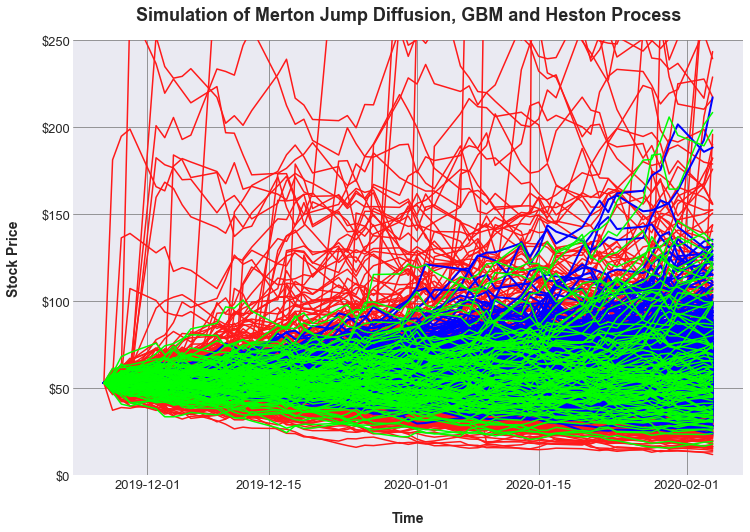

In [71]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1, 1,  figsize = (12, 8))
    plt.plot(jd6.time_grid, path_jd6[:, :p], '#FF1A1A', label = 'Jump Diffusion', linewidth = 1.5)
    plt.plot(hes5.time_grid, path_hes5[:, :p], 'blue', label = 'heston', linewidth = 2)
    plt.plot(gbm3.time_grid, path_gbm3[:, :100], 'lime', label = 'Geometric Brownian Motion', linewidth = 1.5)

    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    plt.grid(True, color = 'grey')
    plt.title('Simulation of Merton Jump Diffusion, GBM and Heston Process', fontweight = 'bold', fontsize = 18, pad = 20)
    plt.ylabel('Stock Price', fontweight = 'bold', fontsize = 14, labelpad = 20)
    plt.xlabel('Time', fontweight = 'bold', fontsize = 14, labelpad = 20)
    plt.ylim(0, 250)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.show()

## Error Analysis

In [72]:
error_jd6 = []
error_gbm3 = []
error_heston5 = []
er_jd6 = []
er_gbm3 = []
er_heston5 = []
for i in range(len(market2)):
    error_jd6.append(((mean_jd6[i] - market2[i])/market2[i])**2)
    error_gbm3.append(((mean_gbm3[i] - market2[i])/market2[i])**2)
    error_heston5.append(((mean_hes5[i] - market2[i])/market2[i])**2)
    er_jd6.append(abs((mean_jd6[i] - market2[i])/market2[i]))
    er_gbm3.append(abs((mean_gbm3[i] - market2[i])/market2[i]))
    er_heston5.append(abs((mean_hes5[i] - market2[i])/market2[i]))
mean_square_error_jd6 = sum(error_jd6)/len(error_jd6)
mean_square_error_gbm3 = sum(error_gbm3)/len(error_gbm3)
mean_square_error_heston5 = sum(error_heston5)/len(error_heston5)

print('\033[1m')
print("Root Mean Square Error:")

from termcolor import colored 
print(colored('Geometric Brownian Motion: {:.5f}', 'red', None, ['bold']).format(math.sqrt(mean_square_error_gbm3)))
print(colored('Merton Jump Diffusion: {:.5f}', 'green', None, ['bold']).format(math.sqrt(mean_square_error_jd6)))
print(colored('Heston Process:  {:.5f}', 'magenta', None, ['bold']).format(math.sqrt(mean_square_error_heston5)))


Root Mean Square Error:
Geometric Brownian Motion: 0.02897
Merton Jump Diffusion: 0.06204
Heston Process:  0.02804


In [73]:
er_heston5 = 100*np.array(er_heston5)
er_gbm3 = 100*np.array(er_gbm3)
er_jd6 = 100*np.array(er_jd6)

In [74]:
import plotly.graph_objects as go
x =  hes5.time_grid
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x = x, y = er_heston5,
                    mode='lines+markers',
                    name='Heston Process',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : 'magenta'}))
fig.add_trace(go.Scatter(x = x, y = er_gbm3,
                    mode='lines+markers',
                    name='Geometric Brownian Motion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#FF1A1A'}))
fig.add_trace(go.Scatter(x = x, y = er_jd6,
                    mode='lines+markers',
                    name='Jump Diffusion',
                    marker = {'symbol' : 'circle-open', 'size' : 7, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color' : '#17BC17'}))


fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 12}),
                  title={'text': "<b>Comparison of Percentage Error at each time step</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Percentage Error</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix=" ", ticksuffix = "%  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

## Call Option Pricing

### GBM

In [75]:
K = []
for i in range(54, 66, 2):
    K.append(i)
    
fig = go.Figure()
symbol = ['star-open', 'circle-open', 'triangle-up-open', 'square-open', 'diamond-open', 'hexagram-open']
j = 0
for k in K:
    C = []
    for i in range(len(market2)):
        c = (1/((1+roi)**((i*2)/365))*(max(mean_gbm3[i] - k, 0)))
        C.append(c)
    fig.add_trace(go.Scatter(x = gbm3.time_grid, y = C,
                    mode='lines+markers',
                    name='Strike Price: $' + str(k),
                    marker = {'symbol' : symbol[j], 'size' : 8, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color': color[j]}))
    j += 1

fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))#, range = (-1, 30)))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b>Call Option Pricing using GBM for various Strike Prices</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Call Option Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.show()

### Merton-Jump Diffusion

In [76]:
K = []
for i in range(54, 66, 2):
    K.append(i)
    
fig = go.Figure()
symbol = ['star-open', 'circle-open', 'triangle-up-open', 'square-open', 'diamond-open', 'hexagram-open']
j = 0
for k in K:
    C = []
    for i in range(len(market2)):
        c = (1/((1+roi)**((i*2)/365))*(max(mean_jd6[i] - k, 0)))
        C.append(c)
    fig.add_trace(go.Scatter(x = jd6.time_grid, y = C,
                    mode='lines+markers',
                    name='Strike Price: $' + str(k),
                    marker = {'symbol' : symbol[j], 'size' : 8, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color': color[j]}))
    j += 1

fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))#, range = (-1, 30)))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b>Call Option Pricing using Merton Jump Diffusion for various Strike Prices</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Call Option Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()

### Heston Process

In [77]:
K = []
for i in range(54, 66, 2):
    K.append(i)
    
fig = go.Figure()
symbol = ['star-open', 'circle-open', 'triangle-up-open', 'square-open', 'diamond-open', 'hexagram-open']
j = 0
for k in K:
    C = []
    for i in range(len(market2)):
        c = (1/((1+roi)**((i*2)/365))*(max(mean_hes5[i] - k, 0)))
        C.append(c)
    fig.add_trace(go.Scatter(x = hes5.time_grid, y = C,
                    mode='lines+markers',
                    name='Strike Price: $' + str(k),
                    marker = {'symbol' : symbol[j], 'size' : 8, 'opacity' : 1},
                    line = {'dash' : 'solid', 'width' : 2.5, 'color': color[j]}))
    j += 1

fig.update_layout(yaxis = dict(tickmode = 'linear', dtick = 2))#, range = (-1, 30)))
fig.update_layout(autosize = False, height = 600, width = 1000)
fig.update_layout(legend = dict(yanchor="top", y=0.99, xanchor="left", x=0.02,
                                bgcolor="Aliceblue", bordercolor="Black", borderwidth=1, font = {"size" : 15}),
                  title={'text': "<b>Call Option Pricing using Heston Process for various Strike Prices</b>", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  uniformtext_minsize = 20, yaxis_title = "<b>Call Option Price</b>", xaxis_title = "<b>Time</b>",
                  font = dict(
                              size=15,
                              color="RebeccaPurple"))
fig.update_yaxes(tickprefix="$", ticksuffix = "  ")
fig.update_xaxes(title_standoff = 0)
fig.show()